# 🧼 Full Data Cleaning for Aesthetic Captioning (Based on clean.py)

## Install & Import Library

In [ ]:
import json
import re
import numpy as np
from collections import Counter, defaultdict
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
from tqdm.notebook import tqdm

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

## Load Raw Data & Inisialisasi

In [ ]:
# Load raw.json
with open('/kaggle/input/raw-food-picture-metadata/raw.json', 'r') as f:
    raw_data = json.load(f)

# Init
tokenizer = RegexpTokenizer(r'\w+\S*\w*')
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))

bad_word_list = [
    'congrats', 'congratulations', 'congratulation',
    'award', 'awards', 'ribbon', 'ribbons',
    "\\u00" # captions with this char must include non-english words
]
replace_word_map = {'colour': 'color'}

unigram_dict = {}
bigram_dict = {}
reason_counter = defaultdict(int)

## Function Pembersih & POS

In [ ]:
def basic_clean(cap):
    cap = cap.lower().replace('\r', ' ')
    for k, v in replace_word_map.items():
        cap = cap.replace(k, v)
    cap = re.sub(r'[0-9]+', '', cap)
    cap = re.sub(r"[^a-z\s]", '', cap)
    return ' '.join(tokenizer.tokenize(cap))

def reduce_word_length(word):
    return re.sub(r'(.)\1{2,}', r'\1', word)

def reduce_cap_length(cap):
    return ' '.join(map(reduce_word_length, cap.split()))

def get_pos(cap):
    return pos_tag(cap.split())

def lemmatize(token_pos):
    result = []
    for word, tag in token_pos:
        if tag.startswith('N'):
            result.append((lemmatizer.lemmatize(word, wordnet.NOUN), tag))
        elif tag.startswith('V'):
            result.append((lemmatizer.lemmatize(word, wordnet.VERB), tag))
        elif tag.startswith('J'):
            result.append((lemmatizer.lemmatize(word, wordnet.ADJ), tag))
        elif tag.startswith('R'):
            result.append((lemmatizer.lemmatize(word, wordnet.ADV), tag))
        else:
            result.append((word, tag))
    return result

def check_bad_words(token_pos):
    return all(word not in bad_word_list for word, _ in token_pos)

## N-gram, Filter, dan Frekuensi

In [ ]:
def update_unigram_freq(unigram):
    if unigram[1].startswith('NN'):
        unigram_dict[unigram[0]] = unigram_dict.get(unigram[0], 0) + 1
        return True
    return False

def update_bigram_freq(bigram):
    tag1, tag2 = bigram[0][1], bigram[1][1]
    if tag1.startswith(('N', 'J', 'R')) and tag2.startswith(('N', 'J')):
        key = bigram[0][0] + '_' + bigram[1][0]
        bigram_dict[key] = bigram_dict.get(key, 0) + 1
        return True
    return False

def update_ngram_freq(token_pos):
    unigrams = [(w, t) for w, t in token_pos if w not in stop]
    bigrams = list(ngrams(unigrams, 2))
    return list(filter(update_unigram_freq, unigrams)), list(filter(update_bigram_freq, bigrams))

## Process Cleaning

In [ ]:
image_list = []
for imgID, meta in tqdm(raw_data.items(), desc='Cleaning'):
    img = {"filename": imgID, "url": meta.get("image_url"), "sentences": []}
    for comment in meta.get("comments", []):
        clean = basic_clean(comment)
        reduced = reduce_cap_length(clean)
        pos_tags = get_pos(reduced)
        lemmatized = lemmatize(pos_tags)

        if not check_bad_words(lemmatized):
            reason_counter["bad_word"] += 1
            continue

        unigrams, bigrams = update_ngram_freq(lemmatized)
        if not unigrams or not bigrams:
            reason_counter["no_ngram"] += 1
            continue

        # Hitung token caption
        tokens = tokenizer.tokenize(reduced)
        token_counts = Counter(tokens)
        max_freq = token_counts.most_common(1)[0][1]
        
        # Jika kata paling sering muncul > 20% dari total kata → skip
        if max_freq / len(tokens) > 0.2:
            reason_counter["repetitive_token"] += 1
            continue
        
        img["sentences"].append({
            "clean": reduced,
            "tokens": tokenizer.tokenize(reduced),
            "unigrams": unigrams,
            "bigrams": bigrams
        })

    if img["sentences"]:
        image_list.append(img)

## Hitung Skor Informativeness

In [ ]:
unigram_score_list = {k: v / sum(unigram_dict.values()) for k, v in unigram_dict.items()}
bigram_score_list = {k: v / sum(bigram_dict.values()) for k, v in bigram_dict.items()}

def tf_idf_score(cap):
    u_score = np.prod([unigram_score_list.get(w[0], 1e-6) for w in cap["unigrams"]])
    b_score = np.prod([bigram_score_list.get(w[0][0] + '_' + w[1][0], 1e-6) for w in cap["bigrams"]])
    total = max(u_score * b_score, 1e-12)
    return -np.log(total) / 2

## Filter & Save

In [ ]:
clean_data = {"images": []}
for img in tqdm(image_list, desc="Filtering"):
    filtered = []
    for cap in img["sentences"]:
        score = tf_idf_score(cap)
        if score < 10:
            reason_counter["too_generic"] += 1
            continue
        if len(cap["tokens"]) < 5:
            reason_counter["too_short"] += 1
            continue
        filtered.append(cap)
    if filtered:
        img["sentences"] = filtered
        clean_data["images"].append(img)

with open("clean.json", "w", encoding="utf-8") as f:
    json.dump(clean_data, f, indent=2, ensure_ascii=False)

print("✔️ Saved clean.json")
print("Reason counts:", dict(reason_counter))
print(f"✅ Final images: {len(clean_data['images'])}")

In [ ]:
print("Statistik pembersihan caption:")
for k, v in reason_counter.items():
    print(f"- {k}: {v}x")

# 🧼 LDA Aesthetic Captioning (Based on LDA.py)

In [ ]:
!pip install gensim pyLDAvis tqdm --quiet

import json, os, io, re
from tqdm.notebook import tqdm
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import numpy as np

## Load clean.json dan Buat Corpus

In [ ]:
with open("/kaggle/working/clean.json", "r", encoding="utf-8") as f:
    image_list = json.load(f)["images"]

def get_all_ngrams(cap):
    unigram_list = cap['unigrams']
    bigram_list = cap['bigrams']
    ngram_list = [[unigram] for unigram in unigram_list] + bigram_list
    final_ngram_list = [' '.join([i[0] for i in ngram]) for ngram in ngram_list]
    return final_ngram_list

def create_corpus(image_list):
    text_corpus = []
    for img in tqdm(image_list, desc="Processed images"):
        captions = img['sentences']
        ngram_list = list(map(get_all_ngrams, captions))
        text_corpus.extend(ngram_list)
    return text_corpus

text_corpus = create_corpus(image_list)

## Create Dictionary dan Term Frequency

In [ ]:
def create_lda_input(text_corpus):
    dictionary = corpora.Dictionary(text_corpus)
    dictionary.filter_extremes(no_below=30, no_above=0.10)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_corpus]
    print(f"dictionary size: {len(dictionary)}, num docs: {len(doc_term_matrix)}")

    # 🔽 Tambahkan penyimpanan file
    os.makedirs("/kaggle/working/lda_output", exist_ok=True)
    dictionary.save("/kaggle/working/lda_output/lda_dictionary.dict")
    corpora.MmCorpus.serialize("/kaggle/working/lda_output/lda_corpus.mm", doc_term_matrix)

    return dictionary, doc_term_matrix

## Train LDA untuk Berbagai Jumlah Topik

In [ ]:
def lda_train(text_corpus, num_topics_start=100, num_topics_end=200):

    topic_range_global = []
    coherence_scores_global = []
    
    dictionary, doc_term_matrix = create_lda_input(text_corpus)
    LDA = gensim.models.ldamulticore.LdaMulticore

    output_dir = "/kaggle/working/lda_output"
    os.makedirs(output_dir, exist_ok=True)

    for num_topics in range(num_topics_start, num_topics_end, 6):
        print(f"Training LDA with {num_topics} topics...")
        lda_model = LDA(
            corpus=doc_term_matrix,
            num_topics=num_topics,
            id2word=dictionary,
            passes=200,
            workers=4,
            iterations=5000,
            chunksize=20000,
            random_state=42  # ⬅️ ini tambahan penting
        )

        # coherence_model = CoherenceModel(
        #     model=lda_model,
        #     corpus=doc_term_matrix,
        #     coherence='u_mass'
        # )

        coherence_model = CoherenceModel(
            model=lda_model,
            texts=text_corpus,  # ditambahkan untuk c_v
            dictionary=dictionary,
            coherence='c_v'
        )

        coherence_score = coherence_model.get_coherence()

        print(f"Coherence score: {coherence_score:.4f}")
        
        coherence_path = f"{output_dir}/lda_coherence_summary.txt"
        with open(coherence_path, "a", encoding="utf-8") as f:
            f.write(f"{num_topics}: {coherence_score:.4f}\n")

        topic_list = lda_model.print_topics(num_topics=num_topics, num_words=20)
        for topic in topic_list:
            print(topic)

        with open(f"{output_dir}/lda_topics_{num_topics}.txt", "w", encoding="utf-8") as f:
            print(coherence_score, file=f)
            for topic in topic_list:
                print(topic[0], "\n", topic[1], "\n", file=f)

        lda_model.save(f"{output_dir}/lda_topics_{num_topics}.model")

        topic_range_global.append(num_topics)
        coherence_scores_global.append(coherence_score)

    # Logging model terbaik
    best_index = np.argmax(coherence_scores_global)
    best_topics = topic_range_global[best_index]
    best_score = coherence_scores_global[best_index]
    print(f"✅ Best model: {best_topics} topics with coherence {best_score:.4f}")
    
    # Simpan info model terbaik
    with open(f"{output_dir}/best_model.txt", "w") as f:
        f.write(f"{best_topics}:{best_score:.4f}\n")

    print("✅ All LDA models trained and saved.")

## Visualisasi

In [ ]:
def lda_visual(model, text_corpus, model_path):
    import pyLDAvis
    import pyLDAvis.gensim_models
    pyLDAvis.enable_notebook()
    
    # Buat nama file HTML berdasarkan nama model
    model_name = os.path.basename(model_path).replace(".model", "")
    save_path = f"/kaggle/working/{model_name}_visualization.html"
    
    # Siapkan corpus
    dictionary, corpus = create_lda_input(text_corpus)
    
    # Buat visualisasi dan simpan
    vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
    pyLDAvis.save_html(vis, save_path)
    
    print(f"✅ Visualisasi disimpan sebagai: {save_path}")

## Training LDA

In [ ]:
lda_train(
    text_corpus=text_corpus,
    num_topics_start=6,
    num_topics_end=66
)

## Load dan Visualisasi

In [ ]:
summary_path = "/kaggle/working/lda_output/lda_coherence_summary.txt"

topic_range = []
coherence_scores = []

# GUNAKAN splitlines() untuk baris asli
with open(summary_path, "r", encoding="utf-8") as f:
    lines = f.read().splitlines()

for line in lines:
    if ":" in line:
        try:
            topic, score = line.strip().split(":")
            topic_range.append(int(topic.strip()))
            coherence_scores.append(float(score.strip()))
        except ValueError:
            print(f"❗ Skipping line (invalid format): {line}")


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(topic_range, coherence_scores, marker="o")
plt.title("LDA Coherence Score (c_v) per Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.xticks(topic_range)
plt.grid(True)
plt.show()

In [ ]:
model_path = "/kaggle/working/lda_output/lda_topics_60.model"
from gensim.models.ldamulticore import LdaMulticore
lda_model = LdaMulticore.load(model_path)

lda_visual(lda_model, text_corpus, model_path)

In [ ]:
from gensim.models.ldamulticore import LdaMulticore

# Load model
model_path = "/kaggle/working/lda_output/lda_topics_60.model"
lda_model = LdaMulticore.load(model_path)

# Tampilkan semua topik dan kata-kata dominannya
# for idx, topic in lda_model.print_topics(num_topics=-1, num_words=15):
#     print(f"🔹 Topic {idx}:\n{topic}\n")
for idx, topic in lda_model.show_topics(num_topics=-1, num_words=15, formatted=False):
    print(f"Topic {idx}:")
    print(" + ".join([f"{word} ({weight:.3f})" for word, weight in topic]))

# 🧼 Classify Topics into 6 Aspects (Based on classify.py)

## Import Lib and Paths

In [ ]:
import os, json
from tqdm import tqdm
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary

# === PATHS ===
input_path = "/kaggle/working/clean.json"
model_path = "/kaggle/working/lda_output/lda_topics_60.model"
dict_path = "/kaggle/working/lda_output/lda_topics_60.model.id2word"
output_dir = "/kaggle/working/aspect_outputs"
os.makedirs(output_dir, exist_ok=True)

## Aspect Mapping

In [ ]:
topic_map = {
    0: "subject",
    1: "color_light",
    2: "composition",
    3: "dof_and_focus",
    4: "general_impression",
    5: "dof_and_focus",
    6: "composition",
    7: "general_impression",
    8: "color_light",
    9: "subject",
    10: "use_of_camera",
    11: "general_impression",
    12: "color_light",
    13: "general_impression",
    14: "composition",
    15: "color_light",
    16: "subject",
    17: "dof_and_focus",
    18: "composition",
    19: "general_impression",
    20: "general_impression",
    21: "composition",
    22: "dof_and_focus",
    23: "dof_and_focus",
    24: "color_light",
    25: "dof_and_focus",
    26: "subject",
    27: "color_light",
    28: "composition",
    29: "composition",
    30: "color_light",
    31: "general_impression",
    32: "composition",
    33: "dof_and_focus",
    34: "dof_and_focus",
    35: "dof_and_focus",
    36: "composition",
    37: "color_light",
    38: "color_light",
    39: "general_impression",
    40: "color_light",
    41: "general_impression",
    42: "general_impression",
    43: "composition",
    44: "color_light",
    45: "general_impression",
    46: "dof_and_focus",
    47: "color_light",
    48: "composition",
    49: "general_impression",
    50: "color_light",
    51: "composition",
    52: "color_light",
    53: "composition",
    54: "dof_and_focus",
    55: "color_light",
    56: "subject",
    57: "color_light",
    58: "general_impression",
    59: "subject",
}

## Check Distribution

In [ ]:
from collections import defaultdict

# Hitung jumlah topik per aspek
aspect_topic_ids = defaultdict(list)
for topic_id, aspect in topic_map.items():
    if aspect != "delete":
        aspect_topic_ids[aspect].append(topic_id)

print("📊 Distribusi topik per aspek:")
for aspect, ids in aspect_topic_ids.items():
    print(f"- {aspect} ({len(ids)} topik): {ids}")

## Classify Process

In [ ]:
# === HELPER: Extract n-grams from sentence
def get_all_ngrams(cap):
    unigrams = cap.get("unigrams", [])
    bigrams = cap.get("bigrams", [])
    ngrams = [[u] for u in unigrams] + bigrams
    return [' '.join([w[0] for w in ng]) for ng in ngrams]

# === HELPER: Get topic from distribution
def get_topic(topic_list):
    valid_topics = [(t_id, prob) for t_id, prob in topic_list if topic_map.get(t_id) != "delete"]
    if not valid_topics:
        return "general_impression"
    best_topic = max(valid_topics, key=lambda x: x[1])[0]
    return topic_map[best_topic]

In [ ]:
lda_model = LdaMulticore.load(model_path)
dictionary = Dictionary.load(dict_path)
with open(input_path, "r", encoding="utf-8") as f:
    data = json.load(f)["images"]

# === INIT RESULT CONTAINER ===
aspect_data = {aspect: {"images": []} for aspect in [
    "color_light", "subject", "composition", "dof_and_focus", "general_impression", "use_of_camera"
]}

# === MAIN CLASSIFICATION LOOP ===
for img in tqdm(data, desc="🔍 Classifying"):
    aspect_sentences = {a: {"filename": img["filename"], "url": img["url"], "sentences": []}
                        for a in aspect_data.keys()}

    for cap in img["sentences"]:
        ngrams = get_all_ngrams(cap)
        filtered = [ng for ng in ngrams if ng in dictionary.token2id]
        bow = dictionary.doc2bow(filtered)

        if not bow:
            continue

        topic_dist = lda_model.get_document_topics(bow)
        aspect = get_topic(topic_dist)
        aspect_sentences[aspect]["sentences"].append(cap["clean"])

    for aspect, content in aspect_sentences.items():
        if content["sentences"]:
            aspect_data[aspect]["images"].append(content)

# === SAVE RESULTS ===
for aspect, content in aspect_data.items():
    with open(os.path.join(output_dir, f"{aspect}.json"), "w", encoding="utf-8") as f:
        json.dump(content, f, indent=2)

print("✅ Semua caption berhasil diklasifikasikan ke 6 aspek estetika.")

In [ ]:
for aspect, content in aspect_data.items():
    print(f"{aspect}: {sum(len(img['sentences']) for img in content['images'])} captions")

In [ ]:
# === SAVE ASPECT SUMMARY ===
aspect_summary = {
    aspect: sum(len(img["sentences"]) for img in content["images"])
    for aspect, content in aspect_data.items()
}
with open(os.path.join(output_dir, "aspect_summary.json"), "w", encoding="utf-8") as f:
    json.dump(aspect_summary, f, indent=2)
print("✅ aspect_summary.json berhasil diperbarui.")

In [ ]:
# Hitung total jumlah caption dari clean.json
with open(input_path, "r", encoding="utf-8") as f:
    data = json.load(f)["images"]

total_caption_count = sum(len(img["sentences"]) for img in data)
print(f"Total caption in clean.json: {total_caption_count}")

⚠️ Caption yang tidak berhasil diklasifikasikan: 1,078 captions

Setelah di-tokenisasi menjadi n-gram (get_all_ngrams()), tidak ada satupun n-gram yang match di dictionary.token2id, sehingga Langsung continue → caption diskip.

# 🧼 Splitting into train, test, val set (Based on split.py)

## Import dan Setup Folder

In [ ]:
import os
import json
import numpy as np
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm

input_path = "/kaggle/working/aspect_outputs"
output_path = "/kaggle/working/final"
os.makedirs(output_path, exist_ok=True)

aspect_name = [
    'color_light.json',
    'composition.json',
    'dof_and_focus.json',
    'general_impression.json',
    'subject.json',
    'use_of_camera.json'
]

all_path = "/kaggle/working/clean.json"
tokenizer = RegexpTokenizer(r'\w+\S*\w*')

## Fungsi Split Index

In [ ]:
def split_indice(img_num: int):
    train_num = int(img_num * 6 / 8)
    val_num = test_num = int(img_num * 1 / 8)

    indices = np.arange(img_num)
    np.random.shuffle(indices)

    train_indice = indices[:train_num]
    val_indice = indices[train_num : train_num + val_num]
    test_indice = indices[train_num + val_num:]

    return train_indice, val_indice, test_indice

## Proses Splitting Per Aspek

In [ ]:
# Proses semua aspek terlebih dahulu
for i, path in enumerate(aspect_name):
    full_path = os.path.join(input_path, path)
    with open(full_path, "r", encoding="utf-8") as f:
        image_list = json.load(f)["images"]

    train_ids, val_ids, test_ids = map(set, split_indice(len(image_list)))
    split_image_list = []

    for imgID, img in enumerate(tqdm(image_list, desc=f"Splitting {path}")):
        if imgID in train_ids:
            img["split"] = "train"
        elif imgID in val_ids:
            img["split"] = "val"
        else:
            img["split"] = "test"

        processed_caps = []
        for cap in img["sentences"]:
            processed_caps.append({
                "raw": cap,
                "tokens": tokenizer.tokenize(cap)
            })

        img["sentences"] = processed_caps
        img["aspect"] = path.replace(".json", "")
        split_image_list.append(img)

    with open(os.path.join(output_path, path), "w", encoding="utf-8") as f:
        json.dump({"images": split_image_list}, f, indent=2)

# Sekarang proses clean.json (all)
with open(all_path, "r", encoding="utf-8") as f:
    image_list = json.load(f)["images"]

train_ids, val_ids, test_ids = map(set, split_indice(len(image_list)))
split_image_list = []

for imgID, img in enumerate(tqdm(image_list, desc="Splitting all.json")):
    if imgID in train_ids:
        img["split"] = "train"
    elif imgID in val_ids:
        img["split"] = "val"
    else:
        img["split"] = "test"

    processed_caps = []
    for cap in img["sentences"]:
        processed_caps.append({
            "raw": cap["clean"],
            "tokens": tokenizer.tokenize(cap["clean"])
        })

    img["sentences"] = processed_caps
    split_image_list.append(img)

with open(os.path.join(output_path, "all.json"), "w", encoding="utf-8") as f:
    json.dump({"images": split_image_list}, f, indent=2)

print("✅ Dataset selesai di-split sesuai format Karpathy ke folder /kaggle/working/final")

In [ ]:
# import shutil

# # Buat ZIP file dari seluruh isi folder
# shutil.make_archive("/kaggle/working/final", 'zip', "/kaggle/working/final")

# 🧼 Preprocess Dataset and Visualisation

## Install dan import package

In [2]:
!pip install --quiet nltk pillow pyspellchecker

import os
import json
import h5py
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import Counter, defaultdict
from spellchecker import SpellChecker
from random import seed, choice, sample

seed(42)
np.random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.8 MB/s eta 0:00:00:00:010:01


In [ ]:
# !pip install --quiet nltk pillow pyspellchecker

# import os
# import json
# import h5py
# import numpy as np
# from collections import Counter
# from random import seed, choice, sample
# from tqdm import tqdm
# from nltk.tokenize import RegexpTokenizer
# from PIL import Image
# from spellchecker import SpellChecker
# import random

# seed(42)
# random.seed(42)
# np.random.seed(42)

## Fungsi load & resize image & Correction token

In [24]:
with open("/kaggle/input/custom-correction-dictionary/missed_words_all.json") as f:
    missed_dict = json.load(f)

In [25]:
def load_glove_vocab(glove_path):
    vocab = set()
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            vocab.add(line.strip().split()[0])
    return vocab


def correct_token(token: str, spell: SpellChecker, glove_vocab: set, missed_dict: dict = None):
    if missed_dict and token in missed_dict and missed_dict[token][0]:
        return missed_dict[token][0]
    if token in glove_vocab:
        return token
    elif token.lower() in glove_vocab:
        return token.lower()
    else:
        correction = spell.correction(token)
        return correction if correction in glove_vocab else token


def build_word_map(captions, glove_vocab, missed_dict=None, min_word_freq=2):
    spell = SpellChecker()
    word_freq = Counter()
    for tokens in captions:
        word_freq.update(tokens)

    words = [w for w in word_freq if word_freq[w] > min_word_freq]
    word_map = {}
    missed = defaultdict(list)

    idx = 1
    for word in sorted(set(words)):
        # corrected = correct_token(word, spell, glove_vocab)
        corrected = correct_token(word, spell, glove_vocab, missed_dict)
        if corrected:
            if corrected not in word_map:
                word_map[corrected] = idx
                idx += 1
            if corrected != word:
                missed[word].append(corrected)
        else:
            missed[word].append(None)

    word_map['<unk>'] = idx
    word_map['<start>'] = idx + 1
    word_map['<end>'] = idx + 2
    word_map['<pad>'] = 0

    return word_map, missed


def encode_caption(tokens, word_map, max_len):
    encoded = [word_map.get(w, word_map['<unk>']) for w in tokens]
    encoded = [word_map['<start>']] + encoded + [word_map['<end>']]
    return encoded + [word_map['<pad>']] * (max_len - len(tokens))


def load_image(image_path, size=256):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((size, size))
    return np.asarray(image).transpose(2, 0, 1)

In [ ]:
# def load_image(path: str, size: int = 256):
#     image = Image.open(path).convert("RGB")
#     image = image.resize((size, size))
#     return np.asarray(image).transpose(2, 0, 1)

# def correct_token(token: str, spell: SpellChecker, glove_vocab: set):
#     if token in glove_vocab:
#         return token
#     elif token.lower() in glove_vocab:
#         return token.lower()
#     else:
#         return spell.correction(token) if spell.correction(token) in glove_vocab else token

## Fungsi Word Map (dengan koreksi ejaan)

In [ ]:
# def full_word_map(min_word_freq: int, json_path: str, output_path: str, dataset_basename: str, glove_path: str):
#     import os
#     import json
#     from collections import Counter, defaultdict
#     from spellchecker import SpellChecker

#     # Load caption data
#     with open(json_path, 'r') as f:
#         data = json.load(f)

#     word_freq = Counter()
#     for img in data['images']:
#         for c in img['sentences']:
#             word_freq.update(c['tokens'])

#     # Load GloVe vocabulary
#     glove_vocab = set()
#     with open(glove_path, 'r', encoding='utf-8') as f:
#         for line in f:
#             word = line.strip().split()[0]
#             glove_vocab.add(word)

#     spell = SpellChecker()

#     words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]

#     corrected_words = []
#     missed_words_dict = defaultdict(list)  # {"original": corrected}

#     for w in words:
#         if w in glove_vocab:
#             corrected_words.append(w)
#         else:
#             corrected = spell.correction(w)
#             if corrected in glove_vocab:
#                 corrected_words.append(corrected)
#                 missed_words_dict[w].append(corrected)
#             else:
#                 # Even spell-corrected version is not in GloVe, fallback to <unk>
#                 missed_words_dict[w].append(None)

#     unique_words = list(sorted(set(corrected_words)))

#     # Build word map
#     word_map = {k: v + 1 for v, k in enumerate(unique_words)}
#     word_map['<unk>'] = len(word_map) + 1
#     word_map['<start>'] = len(word_map) + 1
#     word_map['<end>'] = len(word_map) + 1
#     word_map['<pad>'] = 0

#     # Save word map
#     wordmap_path = os.path.join(output_path, f'wordmap_{dataset_basename}.json')
#     with open(wordmap_path, 'w') as j:
#         json.dump(word_map, j)

#     # Save missed words
#     missed_path = os.path.join(output_path, f'missed_words_{dataset_basename}.json')
#     with open(missed_path, 'w') as m:
#         json.dump(missed_words_dict, m, indent=2)

#     print(f"✅ word_map saved to: {wordmap_path}")
#     print(f"🕵️ missed words saved to: {missed_path}")
#     return word_map

In [26]:
def preprocess_split(split_data, image_folder, output_folder, aspect_name, word_map,
                     split, captions_per_image=5, max_len=100, resized_size=256):
    image_paths, all_captions = [], []

    for item in split_data:
        if item['split'] != split:
            continue
        valid_captions = [c['tokens'] for c in item['sentences'] if 5 <= len(c['tokens']) <= max_len]
        if not valid_captions:
            continue
        image_paths.append(os.path.join(image_folder, item['filename']))
        all_captions.append(valid_captions)

    with h5py.File(os.path.join(output_folder, f'{split}_images_{aspect_name}.hdf5'), 'w') as h:
        h.attrs['captions_per_image'] = captions_per_image
        images = h.create_dataset('images', (len(image_paths), 3, resized_size, resized_size), dtype='uint8')

        encoded_captions, cap_lengths = [], []

        for i, path in enumerate(tqdm(image_paths, desc=f"{split} - {aspect_name}")):
            caps = all_captions[i]
            if len(caps) < captions_per_image:
                caps += [choice(caps) for _ in range(captions_per_image - len(caps))]
            else:
                caps = sample(caps, captions_per_image)

            images[i] = load_image(path, size=resized_size)

            for cap in caps:
                enc = encode_caption(cap, word_map, max_len)
                encoded_captions.append(enc)
                cap_lengths.append(len(cap) + 2)

    with open(os.path.join(output_folder, f'{split}_captions_{aspect_name}.json'), 'w') as f:
        json.dump(encoded_captions, f)
    with open(os.path.join(output_folder, f'{split}_caplength_{aspect_name}.json'), 'w') as f:
        json.dump(cap_lengths, f)

## Image Check

In [5]:
import os, json
with open("/kaggle/working/final/all.json") as f:
    data = json.load(f)["images"]

missing = [img["filename"] for img in data if not os.path.exists(f"/kaggle/input/dpchallenge-images-food-gallery/images/{img['filename']}")]
print("Missing:", missing)

Missing: []


## Fungsi utama preprocess per aspek

In [27]:
def preprocess_all_aspects(input_dir, image_dir, output_dir, glove_path,
                            aspect_names, captions_per_image=5, max_len=100, min_word_freq=2):
    os.makedirs(output_dir, exist_ok=True)
    glove_vocab = load_glove_vocab(glove_path)

    for aspect in aspect_names:
        print(f"\n🚀 Processing {aspect}...")
        with open(os.path.join(input_dir, f"{aspect}.json")) as f:
            data = json.load(f)

        if aspect == "all":
            all_tokens = [s['tokens'] for img in data['images'] for s in img['sentences']]
            # word_map, missed_words = build_word_map(all_tokens, glove_vocab, min_word_freq)
            word_map, missed_words = build_word_map(all_tokens, glove_vocab, missed_dict=missed_dict, min_word_freq=min_word_freq)
            with open(os.path.join(output_dir, f'wordmap_{aspect}.json'), 'w') as j:
                json.dump(word_map, j)
            with open(os.path.join(output_dir, f'missed_words_{aspect}.json'), 'w') as j:
                json.dump(missed_words, j, indent=2)
        else:
            with open(os.path.join(output_dir, f'wordmap_all.json')) as f:
                word_map = json.load(f)

        for split in ['train', 'val', 'test']:
            preprocess_split(
                split_data=data['images'],
                image_folder=image_dir,
                output_folder=output_dir,
                aspect_name=aspect,
                word_map=word_map,
                split=split,
                captions_per_image=captions_per_image,
                max_len=max_len
            )

In [ ]:
# def preprocess_aspect(json_path, image_folder, output_folder, word_map,
#                       base_filename, split, captions_per_image, max_len=100, resized_size=256):
#     with open(json_path, 'r') as f:
#         data = json.load(f)

#     image_paths, image_captions = [], []

#     for img in data['images']:
#         if img['split'] != split:
#             continue
#         captions = [
#             c for c in img['sentences'] 
#             if 5 <= len(c['tokens']) <= max_len
#         ]
#         if not captions:
#             continue
#         image_paths.append(os.path.join(image_folder, img['filename']))
#         image_captions.append(captions)

#     with h5py.File(os.path.join(output_folder, f'{split}_images_{base_filename}.hdf5'), 'w') as h:
#         h.attrs['captions_per_image'] = captions_per_image
#         images = h.create_dataset('images', (len(image_paths), 3, resized_size, resized_size), dtype='uint8')

#         encoded_captions = []
#         cap_lengths = []

#         for i, path in enumerate(tqdm(image_paths, desc=f"{split} images")):
#             caps = image_captions[i]
#             if len(caps) < captions_per_image:
#                 caps += [choice(caps) for _ in range(captions_per_image - len(caps))]
#             else:
#                 caps = sample(caps, k=captions_per_image)

#             assert len(caps) == captions_per_image
#             images[i] = load_image(path, size=resized_size)

#             for cap in caps:
#                 tokens = cap if isinstance(cap, list) else cap.get("tokens", [])
#                 enc = [word_map['<start>']] + [word_map.get(w, word_map['<unk>']) for w in tokens] + [word_map['<end>']]
#                 enc += [word_map['<pad>']] * (max_len - len(tokens))
#                 encoded_captions.append(enc)
#                 cap_lengths.append(len(tokens) + 2)

#         with open(os.path.join(output_folder, f'{split}_captions_{base_filename}.json'), 'w') as f:
#             json.dump(encoded_captions, f)
#         with open(os.path.join(output_folder, f'{split}_caplength_{base_filename}.json'), 'w') as f:
#             json.dump(cap_lengths, f)

#         print(f"🔤 Jumlah kata di word_map: {len(word_map)}")
#         print("Contoh word_map:", list(word_map.items())[:10])

## Run

In [28]:
preprocess_all_aspects(
    input_dir="/kaggle/working/final",
    image_dir="/kaggle/input/dpchallenge-images-food-gallery/images",
    output_dir="/kaggle/working/preprocessed_dataset",
    glove_path="/kaggle/input/glove6b300dtxt/glove.6B.300d.txt",
    aspect_names=[
        "all", "color_light", "composition", "dof_and_focus",
        "general_impression", "subject", "use_of_camera"
    ],
    captions_per_image=5,
    max_len=100,
    min_word_freq=2
)


🚀 Processing all...


test - all: 100%|██████████| 903/903 [00:11<00:00, 77.46it/s]



🚀 Processing color_light...


test - color_light: 100%|██████████| 633/633 [00:07<00:00, 86.82it/s] 



🚀 Processing composition...


test - composition: 100%|██████████| 606/606 [00:06<00:00, 88.04it/s] 



🚀 Processing dof_and_focus...


test - dof_and_focus: 100%|██████████| 572/572 [00:06<00:00, 88.74it/s] 



🚀 Processing general_impression...


test - general_impression: 100%|██████████| 679/679 [00:07<00:00, 90.12it/s] 



🚀 Processing subject...


test - subject: 100%|██████████| 373/373 [00:04<00:00, 88.23it/s]



🚀 Processing use_of_camera...


test - use_of_camera: 100%|██████████| 66/66 [00:00<00:00, 83.95it/s]


In [ ]:
# # Konfigurasi
# input_base = "/kaggle/working/final"
# image_folder = "/kaggle/input/dpchallenge-images-food-gallery/images"
# output_folder = "/kaggle/working/preprocessed_dataset"
# glove_path = "/kaggle/input/glove6b300dtxt/glove.6B.300d.txt"
# captions_per_image = 5
# max_len = 100
# min_word_freq = 2
# resized_size = 256

# aspect_names = ["all", "color_light", "composition", "dof_and_focus", "general_impression", "subject", "use_of_camera"]

# os.makedirs(output_folder, exist_ok=True)

# for aspect in aspect_names:
#     print(f"🚀 Preprocessing {aspect}...")

#     json_path = os.path.join(input_base, f"{aspect}.json")
#     dataset_basename = aspect

#     if aspect == "all":
#         word_map = full_word_map(min_word_freq, json_path, output_folder, dataset_basename, glove_path)
#     else:
#         with open(os.path.join(output_folder, "wordmap_all.json")) as f:
#             word_map = json.load(f)

#     for split in ['train', 'val', 'test']:
#         preprocess_aspect(
#             json_path=json_path,
#             image_folder=image_folder,
#             output_folder=output_folder,
#             word_map=word_map,
#             base_filename=dataset_basename,
#             split=split,
#             captions_per_image=captions_per_image,
#             max_len=max_len,
#             resized_size=resized_size
#         )

# print("✅ Semua aspek selesai dipreproses!")

In [29]:
def check_glove_coverage(word_map, glove_path):
    print("📊 Checking GloVe coverage...")

    # Load GloVe
    glove_vocab = set()
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            word = line.split()[0]
            glove_vocab.add(word)

    # Hitung coverage
    total_words = len(word_map)
    covered = sum(1 for word in word_map if word in glove_vocab)
    coverage = covered / total_words * 100

    # Cetak ringkasan
    print(f"🧠 Total word_map vocabulary: {total_words}")
    print(f"✅ Words found in GloVe: {covered}")
    print(f"📈 Coverage: {coverage:.2f}%")

    # Tampilkan beberapa contoh kata yang tidak ditemukan
    not_found = [word for word in word_map if word not in glove_vocab and word not in ['<pad>', '<start>', '<end>', '<unk>']]
    print("❌ Contoh kata tidak ditemukan di GloVe:", not_found[:10])

    return coverage

In [30]:
glove_path = "/kaggle/input/glove6b300dtxt/glove.6B.300d.txt"  # contoh path
with open("/kaggle/working/preprocessed_dataset/wordmap_all.json", "r") as f:
    word_map = json.load(f)

check_glove_coverage(word_map, glove_path)

📊 Checking GloVe coverage...
🧠 Total word_map vocabulary: 8842
✅ Words found in GloVe: 8577
📈 Coverage: 97.00%
❌ Contoh kata tidak ditemukan di GloVe: ['aestheticsartistic', 'againmessage', 'allwhite', 'altho', 'andwell', 'applegood', 'arnit', 'artefacting', 'backgroundthe', 'backgroundwell']


97.00294051119657

In [23]:
# import os
# import shutil

# output_folder = "/kaggle/working/preprocessed_dataset"

# # Pastikan folder ada
# if os.path.exists(output_folder):
#     # Hapus semua file dan subfolder di dalamnya
#     for fname in os.listdir(output_folder):
#         fpath = os.path.join(output_folder, fname)
#         if os.path.isfile(fpath):
#             os.remove(fpath)
#         elif os.path.isdir(fpath):
#             shutil.rmtree(fpath)

#     print(f"✅ Semua item dalam folder {output_folder} berhasil dihapus.")
# else:
#     print(f"⚠️ Folder {output_folder} tidak ditemukan.")

✅ Semua item dalam folder /kaggle/working/preprocessed_dataset berhasil dihapus.


## Debug

🧩 DEBUGGING ASPECT: COLOR_LIGHT
📦 Total captions: 18950
✏️ Average caption length: 21.55 tokens
❓ <unk> tokens: 8078 (1.98% of total tokens)

📝 Sample captions (decoded):
- you know what i didnt even see this one its such fun would make excellent gift wrap birthday cards i would have given it
- haha well done great title will have the desired effect and i hope it scores well for you great photographic and setup skills a tad grey in areas and vignetting so a little extra work on that but patience and <unk> is generally rewarded
- great movement texture and color
- many sliced apples in this challenge i like that you used different apples to make one slicing
- the lighting on the bottom is good but using a lemon should of had more light shining through

🔢 Top 5 most common words:
- the: 26780x
- a: 13705x
- and: 9804x
- i: 9606x
- of: 8514x


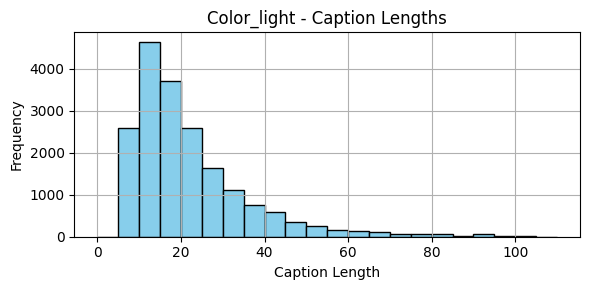


🕵️ Total <unk> appearances: 8078
🧩 DEBUGGING ASPECT: COMPOSITION
📦 Total captions: 18305
✏️ Average caption length: 22.39 tokens
❓ <unk> tokens: 8163 (1.99% of total tokens)

📝 Sample captions (decoded):
- i really like this the only distracting element is the break in the backdrop and its slight dipping to the left
- the background color compliments the dragon very well all the colors are complimentary in fact
- oh this is just sublime absolute the shadow in the top left is especially captivating but the whole difficult composition works beautifully together
- i can see the concept of balance between the celery tomatoes and carrots i think the sandwich takes away from that theme
- i feel that its tough to get a decent image of whole lemons but youve done it here good work

🔢 Top 5 most common words:
- the: 27469x
- a: 12132x
- i: 10714x
- and: 9433x
- <unk>: 8163x


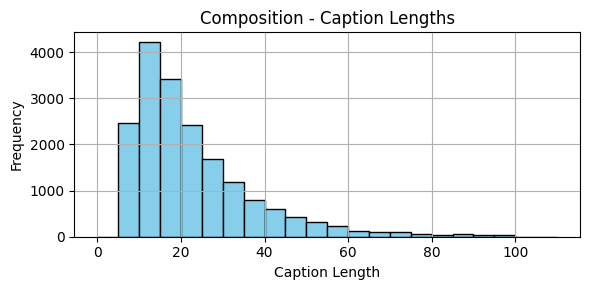


🕵️ Total <unk> appearances: 8163
🧩 DEBUGGING ASPECT: DOF_AND_FOCUS
📦 Total captions: 17120
✏️ Average caption length: 23.16 tokens
❓ <unk> tokens: 7838 (1.98% of total tokens)

📝 Sample captions (decoded):
- nice light and sharpness just feels a little too snap shot like
- woah close up nice abstract quality
- nice simple image fits the theme very well having the matting cover the entire background of the frame helps make the image if there were other background elements then it would be a bit distracting looks like a dogs eye view which is a nice touch too
- the top of the water bottle is slightly out of focus
- <unk> i love the colors of this image but going to bar really wouldnt be that <unk> it but i guess the guy all alone is bored because noone else is there

🔢 Top 5 most common words:
- the: 25764x
- a: 11381x
- i: 10173x
- and: 8913x
- of: 7993x


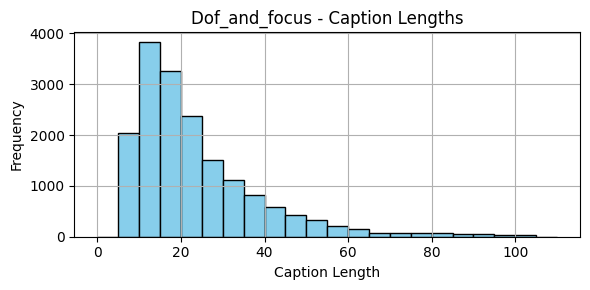


🕵️ Total <unk> appearances: 7838
🧩 DEBUGGING ASPECT: GENERAL_IMPRESSION
📦 Total captions: 20360
✏️ Average caption length: 22.75 tokens
❓ <unk> tokens: 9532 (2.06% of total tokens)

📝 Sample captions (decoded):
- nice idea good job on the execution
- too dark would have liked this picture more with some light in it
- nice idea but a bit cluttered
- the drops on the apple complete this photo very nice
- good idea but not to my liking

🔢 Top 5 most common words:
- the: 28156x
- a: 13134x
- i: 12631x
- <unk>: 9532x
- and: 9356x


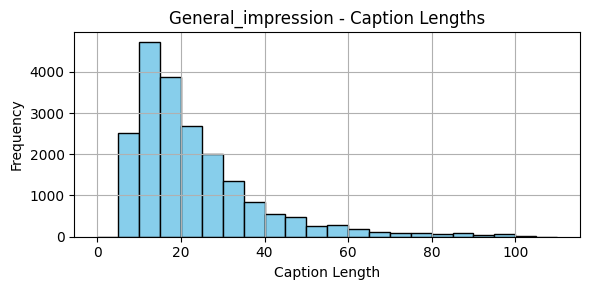


🕵️ Total <unk> appearances: 9532
🧩 DEBUGGING ASPECT: SUBJECT
📦 Total captions: 11125
✏️ Average caption length: 23.94 tokens
❓ <unk> tokens: 5612 (2.11% of total tokens)

📝 Sample captions (decoded):
- perfect exposure key for this type of shot excellent work bumping up
- always with the fortune cookie shots p not bad broken being written has no relevance though as the cookie is clearly the broken thing
- nice id be afraid to do this id figure the golf ball would break the glass
- the <unk> to the <unk> world when going out the world is not so perfect like in your image
- i love the presentation of the food with the spices and <unk> of red color makes it look really appealing

🔢 Top 5 most common words:
- the: 18539x
- a: 7033x
- i: 6662x
- <unk>: 5612x
- and: 5527x


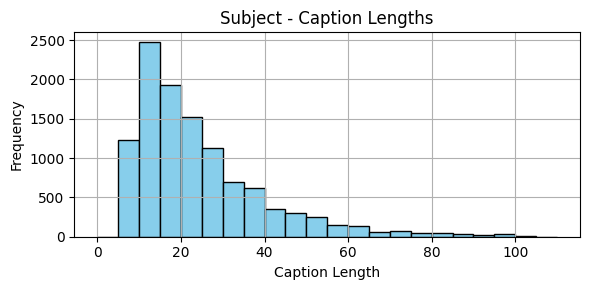


🕵️ Total <unk> appearances: 5612
🧩 DEBUGGING ASPECT: USE_OF_CAMERA
📦 Total captions: 1945
✏️ Average caption length: 28.48 tokens
❓ <unk> tokens: 1310 (2.37% of total tokens)

📝 Sample captions (decoded):
- hope your camera is ok nice
- cute name there is something annoying about this yet compelling to keep looking to work it out
- thats the most gorgeous garlic clove ive ever seen very dreamy lighting and processing something about this looks like a colored pencil drawing or something im not sure what to say about the shade of red but i love it what kind of garlic is it
- i know you are going for a simplistic shot but i feel like something is missing here also it appears like there is something behind the last piece
- intriguing though lacking something to give it scope and probably too centered i think it would work better with a knife and spoon added

🔢 Top 5 most common words:
- the: 2754x
- i: 1648x
- a: 1413x
- something: 1370x
- <unk>: 1310x


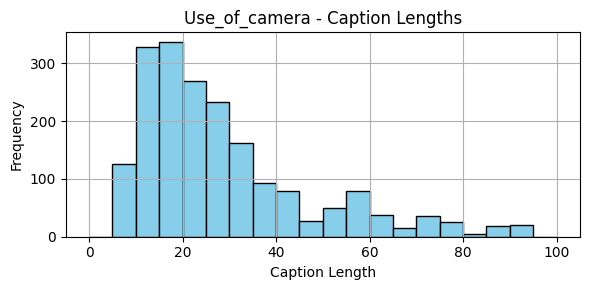


🕵️ Total <unk> appearances: 1310


In [34]:
import json
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Konfigurasi dasar
preprocessed_path = "/kaggle/working/preprocessed_dataset"
wordmap_path = os.path.join(preprocessed_path, "wordmap_all.json")
aspects = ["color_light", "composition", "dof_and_focus", "general_impression", "subject", "use_of_camera"]

# Load word map dan buat reverse map
with open(wordmap_path, "r") as f:
    word_map = json.load(f)
rev_word_map = {v: k for k, v in word_map.items()}
unk_token = word_map["<unk>"]

# Fungsi decode caption token -> teks
def decode_caption(token_list):
    return " ".join([
        rev_word_map.get(t, "<inv>") 
        for t in token_list 
        if t not in {0, word_map["<start>"], word_map["<end>"]}
    ])

# Debugging per aspek
for aspect in aspects:
    print("="*60)
    print(f"🧩 DEBUGGING ASPECT: {aspect.upper()}")

    # Load caption & caplength
    cap_path = os.path.join(preprocessed_path, f"train_captions_{aspect}.json")
    length_path = os.path.join(preprocessed_path, f"train_caplength_{aspect}.json")

    with open(cap_path, "r") as f:
        captions = json.load(f)
    with open(length_path, "r") as f:
        cap_lengths = json.load(f)

    print(f"📦 Total captions: {len(captions)}")
    print(f"✏️ Average caption length: {np.mean(cap_lengths):.2f} tokens")

    # Hitung statistik <unk>
    unk_count = sum(token == unk_token for cap in captions for token in cap)
    total_tokens = sum(cap_lengths)
    unk_ratio = 100 * unk_count / total_tokens
    print(f"❓ <unk> tokens: {unk_count} ({unk_ratio:.2f}% of total tokens)")

    import random

    print("\n📝 Sample captions (decoded):")
    random.shuffle(captions)  # Acak caption
    unique_samples = set()
    shown = 0
    max_samples = 5  # kamu bisa ubah sesuai kebutuhan
    
    for cap in captions:
        decoded = decode_caption(cap)
        if decoded not in unique_samples:
            print(f"- {decoded}")
            unique_samples.add(decoded)
            shown += 1
        if shown >= max_samples:
            break


    # Top 5 tokens
    all_tokens = [
        token for cap in captions 
        for token in cap 
        if token not in {0, word_map["<start>"], word_map["<end>"]}
    ]
    token_freq = Counter(all_tokens)
    most_common_words = [(rev_word_map[t], c) for t, c in token_freq.most_common(5)]
    
    print("\n🔢 Top 5 most common words:")
    for word, count in most_common_words:
        print(f"- {word}: {count}x")

    # Histogram panjang caption
    plt.figure(figsize=(6, 3))
    bins = range(0, max(cap_lengths) + 10, 5)
    plt.hist(cap_lengths, bins=bins, color='skyblue', edgecolor='black')
    plt.title(f"{aspect.capitalize()} - Caption Lengths")
    plt.xlabel("Caption Length")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Opsional: top unk tokens (berdasarkan token id)
    show_top_unk = True
    if show_top_unk:
        unk_words = []
        for cap in captions:
            for token in cap:
                if token == unk_token:
                    unk_words.append(token)
        print(f"\n🕵️ Total <unk> appearances: {len(unk_words)}")


## `<unk>` token checker

In [32]:
import json
import os
from collections import Counter, defaultdict

# Path ke direktori dan file
preprocessed_path = "/kaggle/working/preprocessed_dataset"
wordmap_path = os.path.join(preprocessed_path, "wordmap_all.json")
aspects = ["color_light", "composition", "dof_and_focus", "general_impression", "subject", "use_of_camera"]

# Load word map dan reverse map
with open(wordmap_path, "r") as f:
    word_map = json.load(f)
rev_word_map = {v: k for k, v in word_map.items()}

# Inisialisasi penampung unk_token_counter
unk_token_counter = Counter()
unk_examples_per_aspect = defaultdict(list)

for aspect in aspects:
    print(f"🔍 Scanning aspect: {aspect}")

    cap_path = os.path.join(preprocessed_path, f"train_captions_{aspect}.json")
    with open(cap_path, "r") as f:
        captions = json.load(f)

    for cap in captions:
        for token in cap:
            if token == word_map["<unk>"]:
                continue  # <unk> adalah representasi token hilang
        # Kita tidak bisa tahu token asli dari <unk> kecuali kita logging sebelumnya

        # Alternatif: kita bisa hitung posisi <unk> dan frekuensinya
        unk_count = sum(1 for t in cap if t == word_map["<unk>"])
        if unk_count > 0:
            decoded = " ".join([rev_word_map.get(t, "<unk>") for t in cap if t not in {0, word_map["<start>"], word_map["<end>"]}])
            unk_examples_per_aspect[aspect].append(decoded)

print("\n📌 UNK Examples per Aspect (max 3):")
for aspect, examples in unk_examples_per_aspect.items():
    print(f"\n🔧 {aspect.upper()}")
    for ex in examples[:3]:
        print(f"- {ex}")

# Simpan contoh ke file txt (opsional)
output_path = os.path.join(preprocessed_path, "unk_caption_examples.txt")
with open(output_path, "w") as f:
    for aspect, examples in unk_examples_per_aspect.items():
        f.write(f"=== {aspect.upper()} ===\n")
        for ex in examples[:5]:
            f.write(f"{ex}\n")
        f.write("\n")

print(f"\n✅ Saved UNK caption examples to: {output_path}")


🔍 Scanning aspect: color_light
🔍 Scanning aspect: composition
🔍 Scanning aspect: dof_and_focus
🔍 Scanning aspect: general_impression
🔍 Scanning aspect: subject
🔍 Scanning aspect: use_of_camera

📌 UNK Examples per Aspect (max 3):

🔧 COLOR_LIGHT
- fun <unk> down to the <unk> in the top lively and colorful seems a bit grainy
- fun <unk> down to the <unk> in the top lively and colorful seems a bit grainy
- fun <unk> down to the <unk> in the top lively and colorful seems a bit grainy

🔧 COMPOSITION
- i keep looking at this and the more i look at it the more it appeals to me the composition the colors even the <unk> <unk> in the top right i like it
- i keep looking at this and the more i look at it the more it appeals to me the composition the colors even the <unk> <unk> in the top right i like it
- i keep looking at this and the more i look at it the more it appeals to me the composition the colors even the <unk> <unk> in the top right i like it

🔧 DOF_AND_FOCUS
- i can see a depth of field